<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/image_processing/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digitális képfeldolgozás

A képfeldolgozás során egyik képből egy másik képet készítünk, ennek általában a célja, hogy a képből újabb vagy kévésbé kivehető információhoz jussunk. Tulajdonképpen a jelfeldolgozás egy speciális 2D-s változatával van dolgunk.

A digitális képeket a számítógépeken 2D-s vagy 3D-s tömbökben (mátrixokban tároljuk). A képek pixel sorokból és oszlopokból áll. Az egyes pixelekben az adott pozicióban megjelenítendő szín kódolt értékét tároljuk. A színes képek esetén leggyakrabban RGB kódokat kezelünk, három 0-255 közötti értékekkel. A képfeldolgozás esetén gyakran áttérünk a szürkeárnyalatos vagy fekete-fehér képekre. Ezekben az esetekben képpontonként egy byte vagy egy bit is elegendő a szín információ tárolására.

In [1]:
!wget -O sample_data/adalbert.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/20211022_133458.jpg
import matplotlib.pyplot as plt   # matplotlib grafikus megjelenítéséhez
import matplotlib.image as mpimg  # 
import numpy as np                # mátrix műveletek
import cv2                        # opencv könyvtár képfeldolgozáshoz

--2022-02-24 06:55:38--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/20211022_133458.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1664108 (1.6M) [image/jpeg]
Saving to: ‘sample_data/adalbert.jpg’

sample_data/adalber 100%[===================>]   1.59M  --.-KB/s    in 0.08s   

2022-02-24 06:55:39 (21.0 MB/s) - ‘sample_data/adalbert.jpg’ saved [1664108/1664108]



Színes, szürkeárnyalatos és fekete-fehér kép.

színes képméret: (1536, 2048, 3), szürkeárnyalatos képméret: (1536, 2048)
[[198 194 198 192 196 202 197 196 187 192 193 185 183 191 195]
 [196 202 196 197 175 202 198 203 190 195 194 186 187 191 187]
 [208 203 199 199 184 193 198 192 188 200 195 198 190 192 191]
 [174 212 200 201 195 197 198 206 201 197 198 187 167 190 200]
 [181 205 200 192 182 199 193 192 195 197 199 199 201 198 185]
 [191 199 201 211 206 198 196 183 184 195 202 204 199 166 141]
 [178 204 202 204 194 194 195 200 198 205 191 164 119 139 159]
 [198 195 196 184 178 204 194 204 202 159 121 107 113 139 163]
 [190 189 188 192 196 207 200 157 121 121 133 138 156 173 176]
 [183 195 195 199 202 166 124 119 124 141 152 172 168 120  89]]


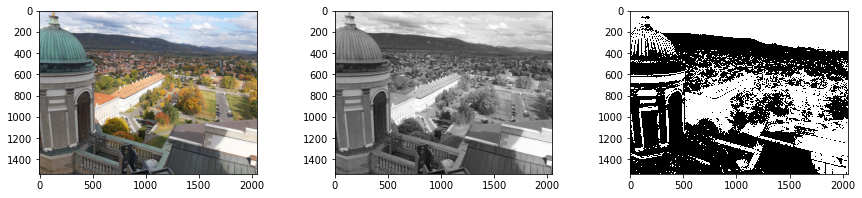

In [4]:
sample_bgr = cv2.imread('sample_data/adalbert.jpg')
sample_gray = cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2GRAY)
thres, sample_bw = cv2.threshold(sample_gray, 127, 255, cv2.THRESH_BINARY)
print(f'színes képméret: {sample_bgr.shape}, szürkeárnyalatos képméret: {sample_gray.shape}')
print('Részlet a kép adataiból')
print(sample_gray[800:810,830:845])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 3)
ax1.imshow(cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB))
ax2.imshow(sample_gray, cmap='gray')
ax3.imshow(sample_bw, cmap='gray', interpolation='nearest')

A képfeldolgotás (image processing), az alakfelismerés (pattern recognition) és a számítógépes grafika (computer graphics) is a digitális képekkel kapcsolatos informatikai területek. A képfeldolgozás során egy képből egy másik képet álltunk elő. Az alakfelismerés során a képből egy általában vektoros leírást állítunk elő. A számítógépes grafika az áltlában vektoros leírásból a képet állítja elő, ezen a területen nagyon gyakran mesterséges intelligencia (gépi tanulás, mély tanulás, stb.) algoritmusokat használnak. Mivel manapság a megjelenítő eszközeink szinte kívétel nélkül raszteres a kép az RGB kódok mátrixban elrendezett értékeit jelenti.

```

                        +-------+  Alakfelismerés  +----------+
                 +----> |       | -------------->  |          |
  Képfeldolgozás |      |  Kép  |                  |  Leírás  |
                 +----- |       | <--------------  |          |
                        +-------+  Számítógépes    +----------+
                                      grafika 
```

Leírás: egyenes (0,0) - (10,10) között


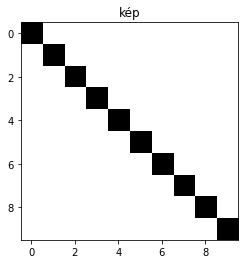

In [11]:
img = 255 - np.eye(10) * 255
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title('kép')
print('Leírás: egyenes (0,0) - (10,10) között')

##Hisztogram

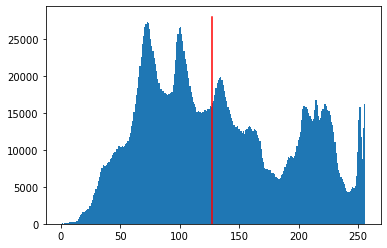

In [17]:
plt.hist(sample_gray.ravel(),256,[0,256])
plt.plot([127, 127], [0, 28000], 'r')

##Adaptív küszöbérték

**TODO** valami vonalas ábra kell félig árnyékban (pl egy gázóra/villanyóra  kijelzője)

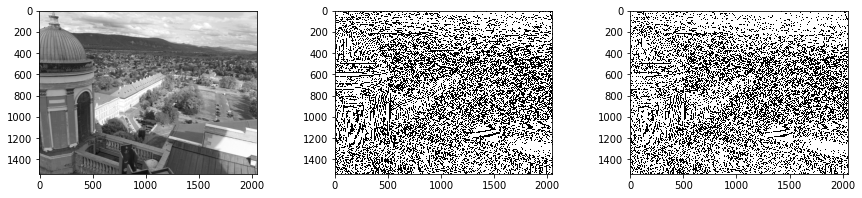

In [21]:
bw1 = cv2.adaptiveThreshold(sample_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
bw2 = cv2.adaptiveThreshold(sample_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 3)
ax1.imshow(sample_gray, cmap='gray')
ax2.imshow(bw1, cmap='gray', interpolation='nearest')
ax3.imshow(bw2, cmap='gray', interpolation='nearest')

#Kontraszt és fényesség

TODO másik kép kell ahol nem a teljes 0-255 tartományban van érték

In [24]:
print(f'{np.min(sample_gray)} {np.max(sample_gray)}')

0 255


Felhasznált források:
https://www.tutorialspoint.com/dip/image_processing_introduction.htm